In [1]:
# https://www.tensorflow.org/tutorials/text/transformer
# https://arxiv.org/abs/2001.08317
# https://arxiv.org/pdf/1907.00235

In [2]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
# get historical daily price
symbol = 'SPY'
ticker = yf.Ticker(symbol)
history = ticker.history(period="max")
print(ticker.ticker,history.shape)

SPY (7029, 7)


In [4]:
df = pd.DataFrame()
df['price'] = history.Close
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
df['ret_mean'] = df.log_ret.rolling(21).mean()
df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
df = df.dropna()
df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)

In [5]:
np.mean(df.hist_vol),np.std(df.hist_vol)

(15.973410095810829, 10.387271561805987)

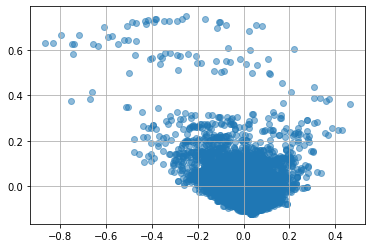

In [6]:
plt.scatter(df.z_ret,df.z_vol,alpha=0.5)
plt.grid(True)

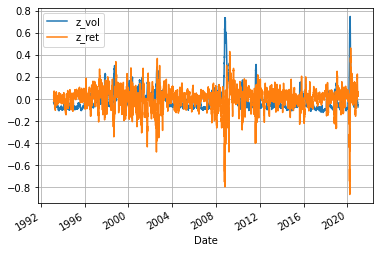

In [7]:
df[['z_vol','z_ret']].plot()
plt.grid(True)

In [8]:
# objectiv
# given x year span of z_vol, z_ret, predict next y day z_vol and z_ret

In [9]:

def etl(history):
    df = pd.DataFrame()
    df['price'] = history.Close
    df.index = history.index
    df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))
    df['ret_mean'] = df.log_ret.rolling(21).mean()
    df['hist_vol'] = df.log_ret.rolling(21).std()*np.sqrt(252)*100
    df = df.dropna()
    df['z_vol']=np.clip(scipy.stats.zscore(df.hist_vol)/10,-1,1)
    df['z_ret']=np.clip(scipy.stats.zscore(df.ret_mean)/10,-1,1)
    df['month']=df.index.month.values/12
    df['day']=df.index.day.values/31
    # add in interest rate.
    return np.stack([df.z_vol.values,df.z_ret.values,df.month.values,df.day.values],axis=-1)

#look_back=252
#look_forward=40
look_back=125
look_forward=8
total_days = look_back+look_forward-1
def chunckify(arr):
    tmp_list = []
    for x in np.arange(total_days,arr.shape[0]-total_days,5):
        tmp = arr[x:x+total_days]
        if tmp.shape != (total_days,4):
            continue
        x,y = tmp[:-1*look_forward,:],tmp[-1*look_forward:,:]
        tmp_list.append((x,y))
    return tmp_list


final_list = []
symbols = [
    'IWM','SPY','QQQ','GLD','SLV',
]
ticker_list = yf.Tickers(' '.join(symbols))
for ticker in ticker_list.tickers:
    history = ticker.history(period="max")
    print(ticker.ticker,history.shape)
    arr = etl(history)
    if arr.shape[0] > total_days:
        tmp_list = chunckify(arr)
        final_list.extend(tmp_list)

IWM (5179, 7)
SPY (7029, 7)
QQQ (5487, 7)
GLD (4054, 7)
SLV (3692, 7)


In [10]:
len(final_list),final_list[0][0].shape,final_list[0][1].shape

(4805, (124, 4), (8, 4))

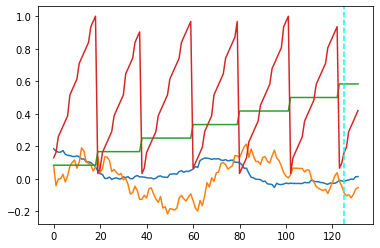

In [11]:
a=final_list[0][0]
b=final_list[0][1]
plt.plot(np.concatenate([a,b]))
plt.axvline(look_back,linestyle='--',color='cyan')

In [12]:
X = np.stack([x[0][:,:] for x in final_list],axis=0).astype(np.float32)
y = np.stack([x[1][:,:] for x in final_list],axis=0).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)


(3219, 124, 4) (3219, 8, 4) (1586, 124, 4) (1586, 8, 4)


In [13]:
#https://www.tensorflow.org/tutorials/text/transformer
#http://jalammar.github.io/illustrated-transformer

In [14]:
import os
import tensorflow_datasets as tfds
import tensorflow as tf
import yaml
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
data_exists = os.path.exists('X_train.npy')
if data_exists:
    X_train = np.load('X_train.npy')
    X_test = np.load('X_test.npy')
    y_train = np.load('y_train.npy')
    y_test = np.load('y_test.npy')
print(X_test.shape,y_test.shape)

(251992, 124, 4) (251992, 8, 4)


(14, 11)


<Figure size 432x288 with 0 Axes>

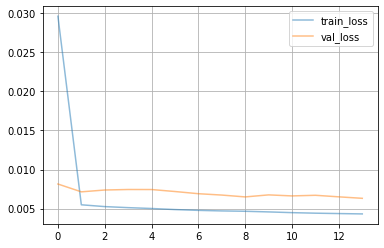

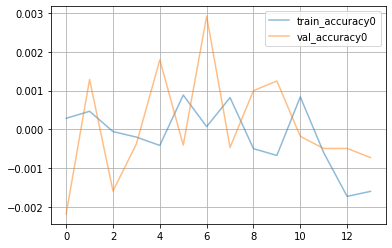

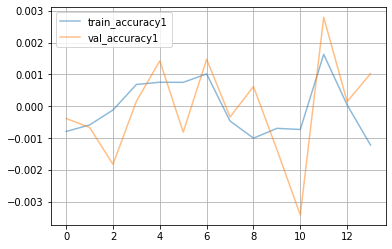

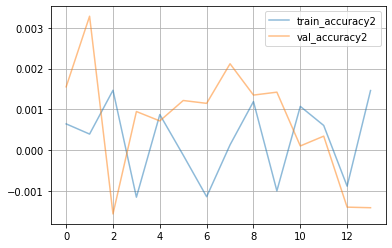

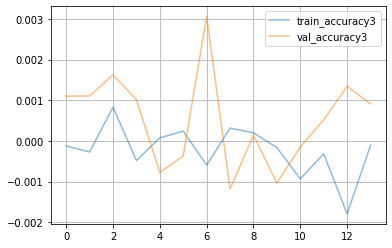

In [33]:
with open('history.yml','r') as f:
    history = yaml.unsafe_load(f.read())

df = pd.DataFrame(history)
print(df.shape)
plt.figure(0)
df[['train_loss','val_loss']].plot(alpha=0.5)
plt.grid(True)
plt.figure(1)
df[['train_accuracy0','val_accuracy0']].plot(alpha=0.5)
plt.grid(True)
plt.figure(2)
df[['train_accuracy1','val_accuracy1']].plot(alpha=0.5)
plt.grid(True)
plt.figure(3)
df[['train_accuracy2','val_accuracy2']].plot(alpha=0.5)
plt.grid(True)
plt.figure(4)
df[['train_accuracy3','val_accuracy3']].plot(alpha=0.5)
plt.grid(True)


In [29]:
input_seq_len = 124
target_seq_len = 8
batch_size = 32

num_layers = 4
d_model = 4
dff = 4
num_heads = 4
dropout_rate = 0.1

from train import Transformer,CustomSchedule,create_masks

loss_object = tf.keras.losses.Huber(delta=2.0)

def loss_function(real, pred):
    loss_ = loss_object(real, pred)
    return tf.reduce_sum(loss_)

#"acc..."
def accuracy_function(real, pred):
    accuracies = loss_object(real, pred)
    return tf.reduce_sum(accuracies)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

#############

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

########

transformer = Transformer(num_layers, d_model, num_heads, dff ,rate=dropout_rate,target_seq_len=target_seq_len)

########

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')



Latest checkpoint restored!!


In [30]:
def evaluate(inp,tar):
    
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp[:,:,0], tar[:,:,0])
    
    predictions, attention_weights = transformer(inp, tar,
                                                 False,
                                                 enc_padding_mask,
                                                 look_ahead_mask,
                                                 dec_padding_mask)

    return predictions, attention_weights

def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

#translate("este é um problema que temos que resolver.")
#print ("Real translation: this is a problem we have to solve .")

(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)
(1, 124, 4) (1, 8, 4)


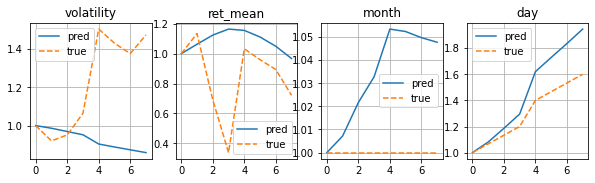

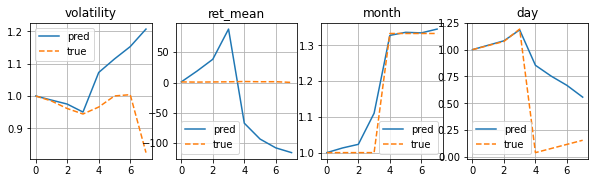

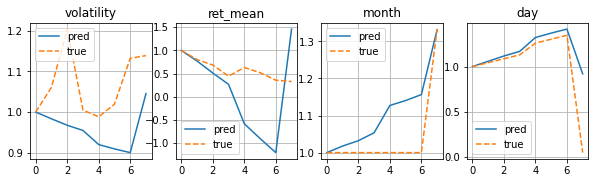

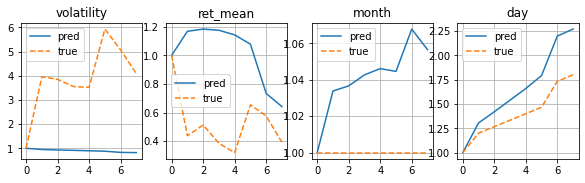

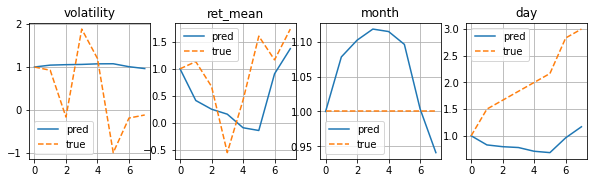

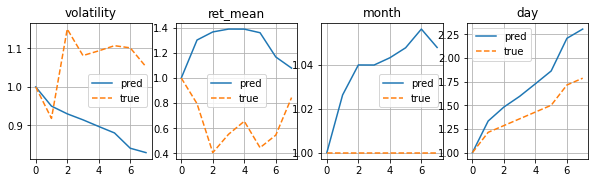

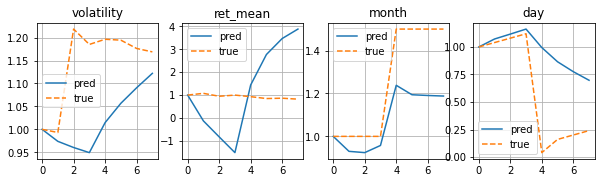

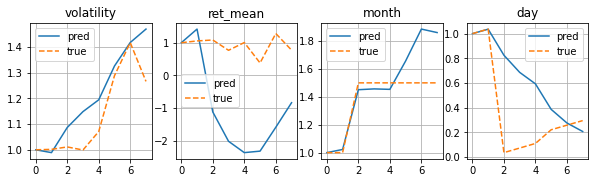

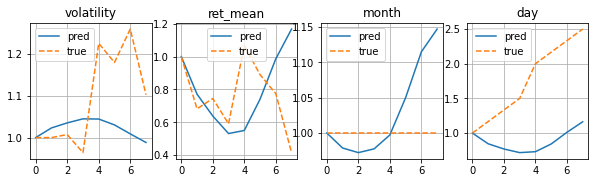

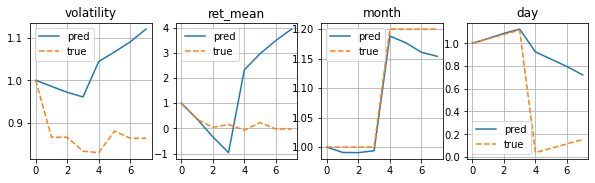

In [32]:
norm = True
for x in np.arange(10,20,1):
    inp,tar = X_test[x,:].squeeze(),y_test[x,:].squeeze()
    inp = np.expand_dims(inp,axis=0)
    tar = np.expand_dims(tar,axis=0)
    print(inp.shape,tar.shape)
    result, attention_weights = evaluate(inp,tar)
    
    for ind,subplot,title in [
        (0,141,'volatility'),
        (1,142,'ret_mean'),
        (2,143,'month'),
        (3,144,'day')

    ]:
        plt.figure(x,figsize=(10,2.5))
        plt.subplot(subplot)
        pred = result.numpy().squeeze()[:,ind]
        true = tar.squeeze()[:,ind]
        if norm:
            pred/=result.numpy().squeeze()[0,ind]
            true/=tar.squeeze()[0,ind]
        plt.plot(pred,label='pred')
        plt.plot(true,linestyle='--',label='true')
        plt.legend()
        plt.title(title)
        plt.grid(True)
    